# 4.4 과대적합과 과소적합
- **과대적합**(overfitting) : 홀드아웃 데이터에서 모델의 성능이 몇 번의 에포크 후에 최고치에 다다랐다가 감소
- 최적화와 일반화 사이의 줄다리기
    - **최적화**(optimization) : 가능한 훈련 데이터에서 최고의 성능을 얻으려고 모델을 조정하는 과정
    - **일반화**(generalization) : 훈련된 모델이 이전에 본 적 없는 데이터에서 얼마나 잘 수행되는지
- **과소적합**(underfitting) : 훈련 데이터의 손실이 낮아질수록 테스트 데이터의 손실도 낮아짐
    - 모델의 성능이 계속 발전될 여지가 있는 경우
- 관련성이 없고 좋지 못한 패턴을 훈련 데이터에서 학습하지 못하게 하는 **가장 좋은 방법은 더 많은 훈련 데이터를 모으는 것**
- **규제**(regularization) : 차선책은 모델이 수용할 수 있는 정보의 양을 조절하거나 저장할 수 있는 정보에 제약을 가하는 것

## 4.4.1 네트워크 크기 축소
- 과대적합을 막는 가장 단순한 방법 : 모델의 크기(학습 파라미터의 수; 용량(capacity))를 줄이는 것
- 기억 용량이 많은 모델은 일반화 능력이 낮음
- 과소적합이 되지 않도록 충분한 파라미터를 가진 모델을 사용해야 함
- 알맞은 층의 수나 각 층의 유닛 수를 결정할 수 있는 공식은 없음
- 알맞은 모델 크기를 찾으려면 각기 다른 구조를 평가해 보아야 함

### 영화 리뷰 분류 모델에 적용

In [1]:
from tensorflow.keras.datasets import imdb
import numpy as np

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = np.array(train_labels).astype('float32')
y_test = np.array(test_labels).astype('float32')

In [2]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

### 원본 모델

In [3]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

history_orig = model.fit(partial_x_train, partial_y_train, verbose=0, 
                   epochs=20, batch_size=512, validation_data=(x_val, y_val))

### 작은 용량의 모델

In [4]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Dense(6, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(6, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

history_small = model.fit(partial_x_train, partial_y_train, verbose=0, 
                   epochs=20, batch_size=512, validation_data=(x_val, y_val))

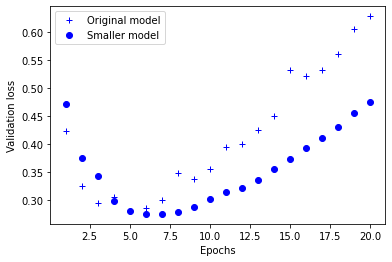

In [5]:
import matplotlib.pyplot as plt

val_loss_orig = history_orig.history['val_loss']
val_loss_small = history_small.history['val_loss']

epochs = range(1, len(val_loss_orig) + 1)

plt.plot(epochs, val_loss_orig, 'b+', label='Original model')
plt.plot(epochs, val_loss_small, 'bo', label='Smaller model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

### 큰 용량의 모델

In [7]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Dense(1024, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

history_big = model.fit(partial_x_train, partial_y_train, verbose=0, 
                   epochs=20, batch_size=512, validation_data=(x_val, y_val))

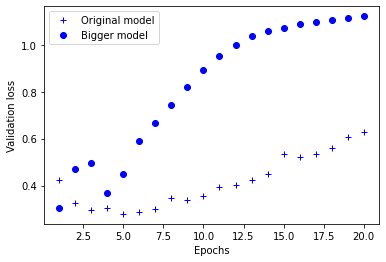

In [8]:
import matplotlib.pyplot as plt

val_loss_orig = history_orig.history['val_loss']
val_loss_big = history_big.history['val_loss']

epochs = range(1, len(val_loss_orig) + 1)

plt.plot(epochs, val_loss_orig, 'b+', label='Original model')
plt.plot(epochs, val_loss_big, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

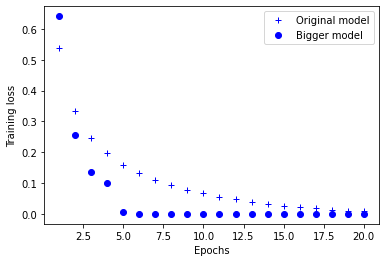

In [9]:
training_loss_orig = history_orig.history['loss']
training_loss_big = history_big.history['loss']

epochs = range(1, len(training_loss_orig) + 1)

plt.plot(epochs, training_loss_orig, 'b+', label='Original model')
plt.plot(epochs, training_loss_big, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend()

plt.show()

## 4.4.2 가중치 규제 추가
- **오캄의 면도날**(Occam's razor) : 어떤 것에 대한 두 가지의 설명이 있다면 더 적은 가정이 필요한 간단한 설명이 옳을 것이라는 이론, 신경망에도 적용됨
- 간단한 모델이 복잡한 모델보다 덜 과대적합될 가능성이 높음
    - 간단한 모델 : 파라미터 값 분포의 엔트로피가 작은 모델 (또는 적은 수의 파라미터를 가진 모델)
- **가중치 규제**(weight regularization) : 네트워크의 복잡도에 제한을 두어 가중치가 작은 값을 가지도록 강제하는 것
    - **L1 규제** : 가중치의 절댓값에 비례하는 비용 추가
    - **L2 규제** : 가중치의 제곱에 비례하는 비용 추가, **가중치 감쇠**(weight decay)라고도 함

### 모델에 L2 가중치 추가하기
- `regularizers.l2()` = `regularizers.L1L2(l2=0.001)` : 가중치 행렬의 모든 원소를 제곱하고 0.001을 곱하여 네트워크의 전체 손실에 더한다는 의미
- 훈련할 때만 추가되며 테스트보다 높을 수 있음

In [11]:
from tensorflow.keras import models, layers, regularizers

model = models.Sequential()
model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                       activation='relu', input_shape=(10000, )))
model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                       activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

history_l2 = model.fit(partial_x_train, partial_y_train, verbose=0, 
                   epochs=20, batch_size=512, validation_data=(x_val, y_val))

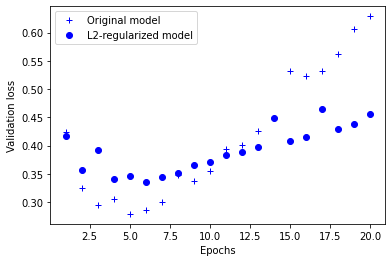

In [13]:
val_loss_orig = history_orig.history['val_loss']
val_loss_l2 = history_l2.history['val_loss']

epochs = range(1, len(val_loss_orig) + 1)

plt.plot(epochs, val_loss_orig, 'b+', label='Original model')
plt.plot(epochs, val_loss_l2, 'bo', label='L2-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

### 케라스에서 사용할 수 있는 가중치 규제

```python
from tensorflow.keras import regularizers

regularizers.l1(0.001) # L1 규제

regularizers.l1_l2(l1=0.001, l2=0.001) # L1과 L2 규제 병행
```

## 4.4.3 드롭아웃 추가
- **드롭아웃**(Dropout) : 토론토 대학의 제프리 힌튼과 그의 학생들이 개발한 것으로, 규제 기법 중 가장 효과적이고 널리 사용되는 방법 중 하나
    - 훈련하는 동안 무작위로 층의 일부 출력 특성을 제외시킴(0으로 만듦)
    - 예) 정상적인 모델이 [0.2, 0.5, 1.3, 0.8, 1.1] 벡터를 출력할 때 드롭아웃을 적용하면 [0, 0.5, 1.3, 0, 1.1]처럼 무작위로 0으로 만듦
    - 드롭아웃 비율 : 0이 될 특성의 비율로 보통 0.2에서 0.5 사이로 지정
- 테스트 단계에서는 어떤 유닛도 드롭아웃 되지 않음
    - 그 대신 층의 출력을 드롭아웃 비율에 비례하여 줄여줌

```python
# 크기가 (batch_size, features)인 한 층의 출력을 담고 있는 넘파이 행렬에 대하여
layer_output *= np.random.randint(0, high=2, size=layer_output.shape) # 훈련할 때 유닛 출력 중 50%를 버림

# 테스트할 때 드롭아웃 비율로 출력을 낮춰줌
layer_output *= 0.5 # 테스트 단계

# 또는 테스트할 때 출력을 그대로 두고 훈련할 때 스케일을 높임
layer_output *= np.random.randint(0, high=2, size=layer_output.shape) # 훈련 단계
layer_output /= 0.5 # 스케일을 낮추는 대신 높임
```

- 왜 드롭아웃이 과대적합을 줄이는 데 도움이 될까?
    - 힌튼이 은행에서 사용하는 부정 방지 메커니즘에서 착안했다고 함
    - 각 샘플에 대해 뉴런의 일부를 무작위하게 제거하면 뉴런의 부정한 협업을 방지하고 과대적합을 감소시킨다는 것을 깨달았다고 함

### IMDB 네트워크에 드롭아웃 추가하기
- `model.add(layers.Dropout(0.5))`

In [14]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000, )))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

history_dropout = model.fit(partial_x_train, partial_y_train, verbose=0, 
                   epochs=20, batch_size=512, validation_data=(x_val, y_val))

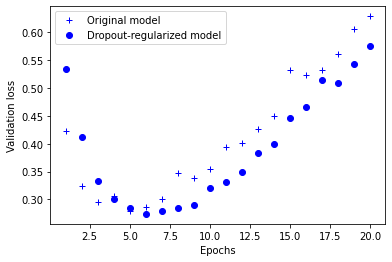

In [15]:
val_loss_orig = history_orig.history['val_loss']
val_loss_dropout = history_dropout.history['val_loss']

epochs = range(1, len(val_loss_orig) + 1)

plt.plot(epochs, val_loss_orig, 'b+', label='Original model')
plt.plot(epochs, val_loss_dropout, 'bo', label='Dropout-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

### 과대적합을 방지하기 위한 방법 정리
- 훈련 데이터를 더 수집
- 네트워크 용량 감소
- 가중치 규제 추가
- 드롭아웃 추가